In [1]:
import ismrmrd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ui.selectionui import get_selection

vs_mdlsub_fname = 'output_recons/vol0912_20240626/viewsharing_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_mdlsub.mrd'
vs_editer_fname = 'output_recons/vol0912_20240626/viewsharing_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_editer.mrd'
ttv_mdlsub_fname = 'output_recons/vol0912_20240626/ttv_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_mdlsub.mrd'
ttv_editer_fname = 'output_recons/vol0912_20240626/ttv_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_editer.mrd'

In [2]:
def readframe_from_mrd(filename, frame_idx) -> np.ndarray:
    with h5py.File(filename, 'r') as d:
        dset_names = list(d.keys())
        print(f'File {filename} contains {len(dset_names)} groups (reconstruction runs):')
        print(' ', '\n  '.join(dset_names))

    if len(dset_names) > 1:
        group = get_selection(dset_names)
    else:
        group = dset_names[0]

    with ismrmrd.Dataset(filename, group, False) as dset:
        subgroups = dset.list()
        imgGroups = [group for group in list(subgroups) if (group.find('image_') != -1)]
        imgGrp = imgGroups[0]
        frame = dset.read_image(imgGrp, frame_idx)
        img = np.squeeze(frame.data)
    return img

def centered_crop(img, crop_size):
    crop_size = np.array(crop_size)
    img_shape = np.array(img.shape)
    crop_start = (img_shape - crop_size) // 2
    crop_end = crop_start + crop_size
    return img[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1]]

In [3]:
vs_frame = 178
ttv_frame = round(vs_frame/7*17)
im_vs_mdlsub = centered_crop(np.flipud(np.rot90(readframe_from_mrd(vs_mdlsub_fname, vs_frame), -1)), 120)
im_vs_editer = centered_crop(np.flipud(np.rot90(readframe_from_mrd(vs_editer_fname, vs_frame), -1)), 120)
im_ttv_mdlsub = centered_crop(np.flipud(np.rot90(readframe_from_mrd(ttv_mdlsub_fname, ttv_frame), -1)), 120)
im_ttv_editer = centered_crop(np.flipud(np.rot90(readframe_from_mrd(ttv_editer_fname, ttv_frame), -1)), 120)


File output_recons/vol0912_20240626/viewsharing_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_mdlsub.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-09-13 17:09:50.851085
File output_recons/vol0912_20240626/viewsharing_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_editer.mrd contains 1 groups (reconstruction runs):
  viewsharing_2024-09-15 15:13:14.966655
File output_recons/vol0912_20240626/ttv_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_mdlsub.mrd contains 1 groups (reconstruction runs):
  ttv_2024-09-23 13:53:44.828693
File output_recons/vol0912_20240626/ttv_meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_editer.mrd contains 1 groups (reconstruction runs):
  ttv_2024-09-23 13:43:28.608964


# Figure 2

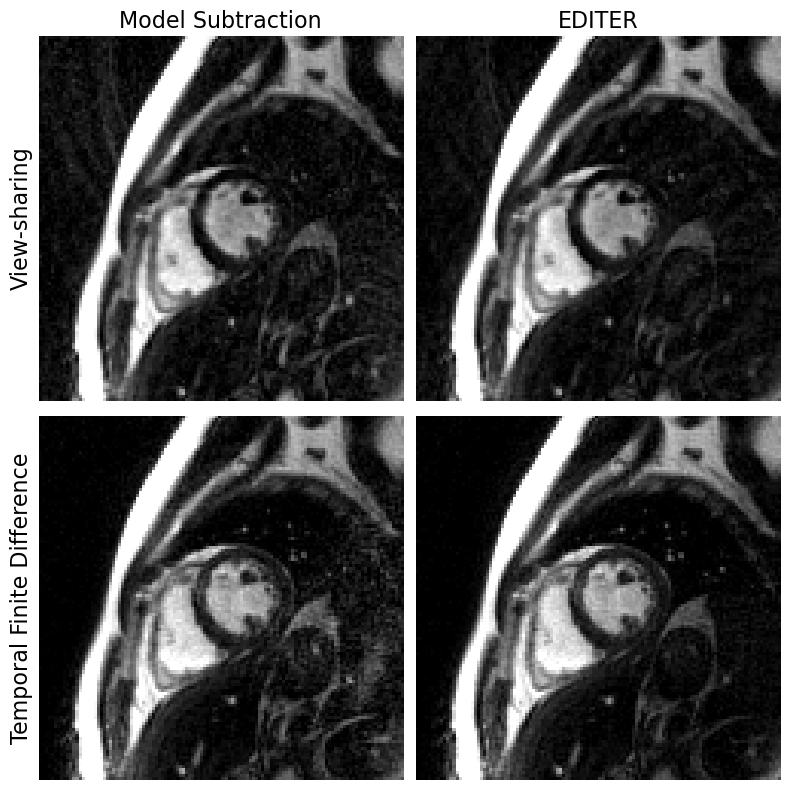

In [21]:
vmin = np.percentile(im_vs_mdlsub, 5)
vmax = np.percentile(im_vs_mdlsub, 95)
fs = 16

f, axs = plt.subplots(2, 2)
f.set_size_inches(8, 8)
axs[0, 0].imshow(np.abs(im_vs_mdlsub), cmap='gray', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Model Subtraction', fontsize=fs)
axs[0, 0].set_ylabel('View-sharing', fontsize=fs)
axs[0, 0].axes.get_xaxis().set_visible(False)
axs[0, 0].axes.get_yaxis().set_ticks([])
axs[0, 0].spines['left'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['bottom'].set_visible(False)

axs[0, 1].imshow(np.abs(im_vs_editer), cmap='gray', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('EDITER', fontsize=fs)
axs[0, 1].axis('off')



axs[1, 0].imshow(np.abs(im_ttv_mdlsub), cmap='gray', vmin=vmin, vmax=vmax)
axs[1, 0].set_ylabel('Temporal Finite Difference', fontsize=fs)
axs[1, 0].axes.get_xaxis().set_visible(False)
axs[1, 0].axes.get_yaxis().set_ticks([])
axs[1, 0].spines['left'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['bottom'].set_visible(False)

axs[1, 1].imshow(np.abs(im_ttv_editer), cmap='gray', vmin=vmin, vmax=vmax)
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

f.savefig('output_recons/vol0912_20240626/compare_recons.svg', dpi=256)